# Time Series Data Mining for Retail Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load the data
# Assuming data is in a CSV file where the first column is StoreID and remaining columns are dates
df = pd.read_csv('../data/sample-2/processed/revenue_ts_matrix.csv')

# Transform the data from wide to long format for easier analysis
df_long = df.melt(id_vars='StoreID', var_name='Date', value_name='Sales')
df_long['Date'] = pd.to_datetime(df_long['Date'])

# Create a pivot table with dates as index and stores as columns
store_data = df_long.pivot(index='Date', columns='StoreID', values='Sales')
store_data.columns = [f'Store_{i}' for i in store_data.columns]

# Check data overview
print(f"Data shape: {store_data.shape}")
print(f"Date range: {store_data.index.min()} to {store_data.index.max()}")

Data shape: (181, 8)
Date range: 2022-01-01 00:00:00 to 2022-06-30 00:00:00


## Exploratory Data Analysis with Interactive Visualizations

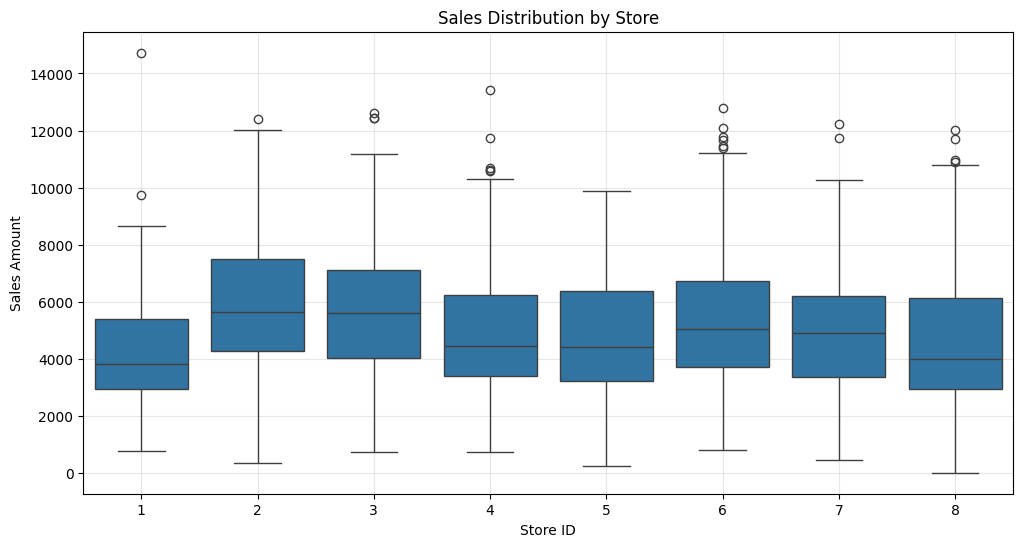

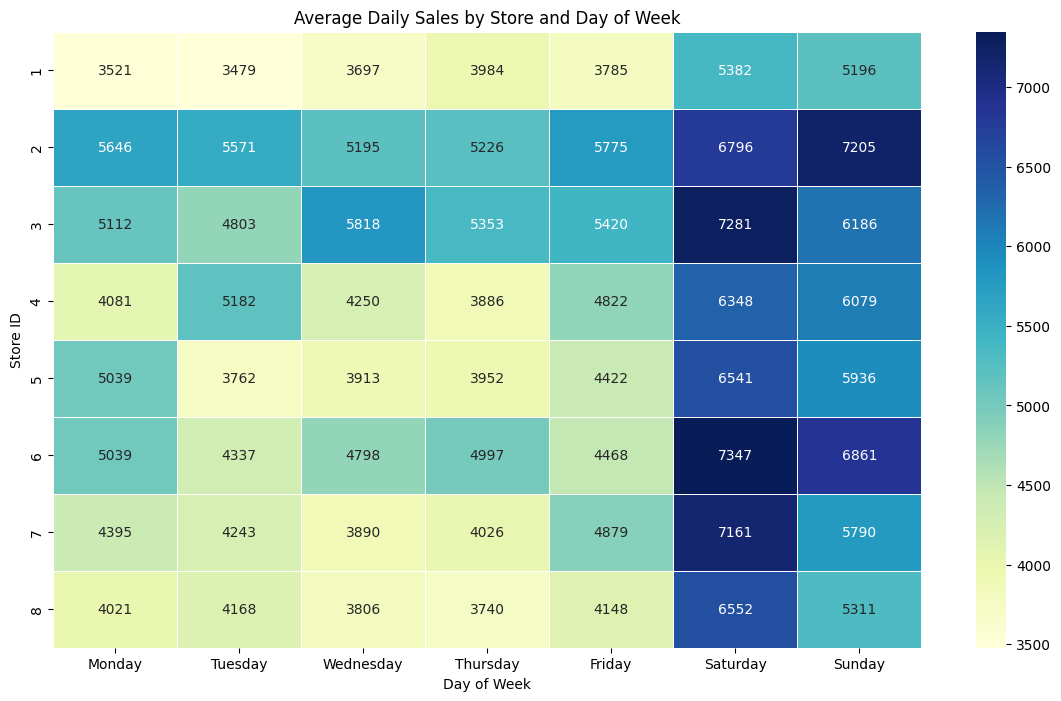

In [2]:
# 2.1 Time Series Plot with Plotly
fig = px.line(
    df_long, 
    x='Date', 
    y='Sales', 
    color='StoreID',
    title='Daily Sales by Store',
    labels={'Sales': 'Sales Amount', 'Date': 'Date'},
)
fig.update_layout(height=600, legend_title_text='Store ID')
fig.show()

# 2.2 Store Comparison - Boxplot of Daily Sales Distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='StoreID', y='Sales', data=df_long)
plt.title('Sales Distribution by Store')
plt.xlabel('Store ID')
plt.ylabel('Sales Amount')
plt.grid(True, alpha=0.3)
plt.show()

# 2.3 Heatmap of Sales by Store and Day of Week
df_long['DayOfWeek'] = df_long['Date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = df_long.pivot_table(
    index='StoreID', 
    columns='DayOfWeek', 
    values='Sales', 
    aggfunc='mean'
)[day_order]

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=0.5)
plt.title('Average Daily Sales by Store and Day of Week')
plt.ylabel('Store ID')
plt.xlabel('Day of Week')
plt.show()

# 2.4 Monthly Sales Trends
df_long['YearMonth'] = df_long['Date'].dt.strftime('%Y-%m')
monthly_sales = df_long.groupby(['YearMonth', 'StoreID'])['Sales'].sum().reset_index()

fig = px.line(
    monthly_sales,
    x='YearMonth',
    y='Sales',
    color='StoreID',
    markers=True,
    title='Monthly Sales Trends by Store'
)
fig.update_layout(xaxis_title='Month', yaxis_title='Total Sales')
fig.show()

## Time Series Decomposition and Patterns

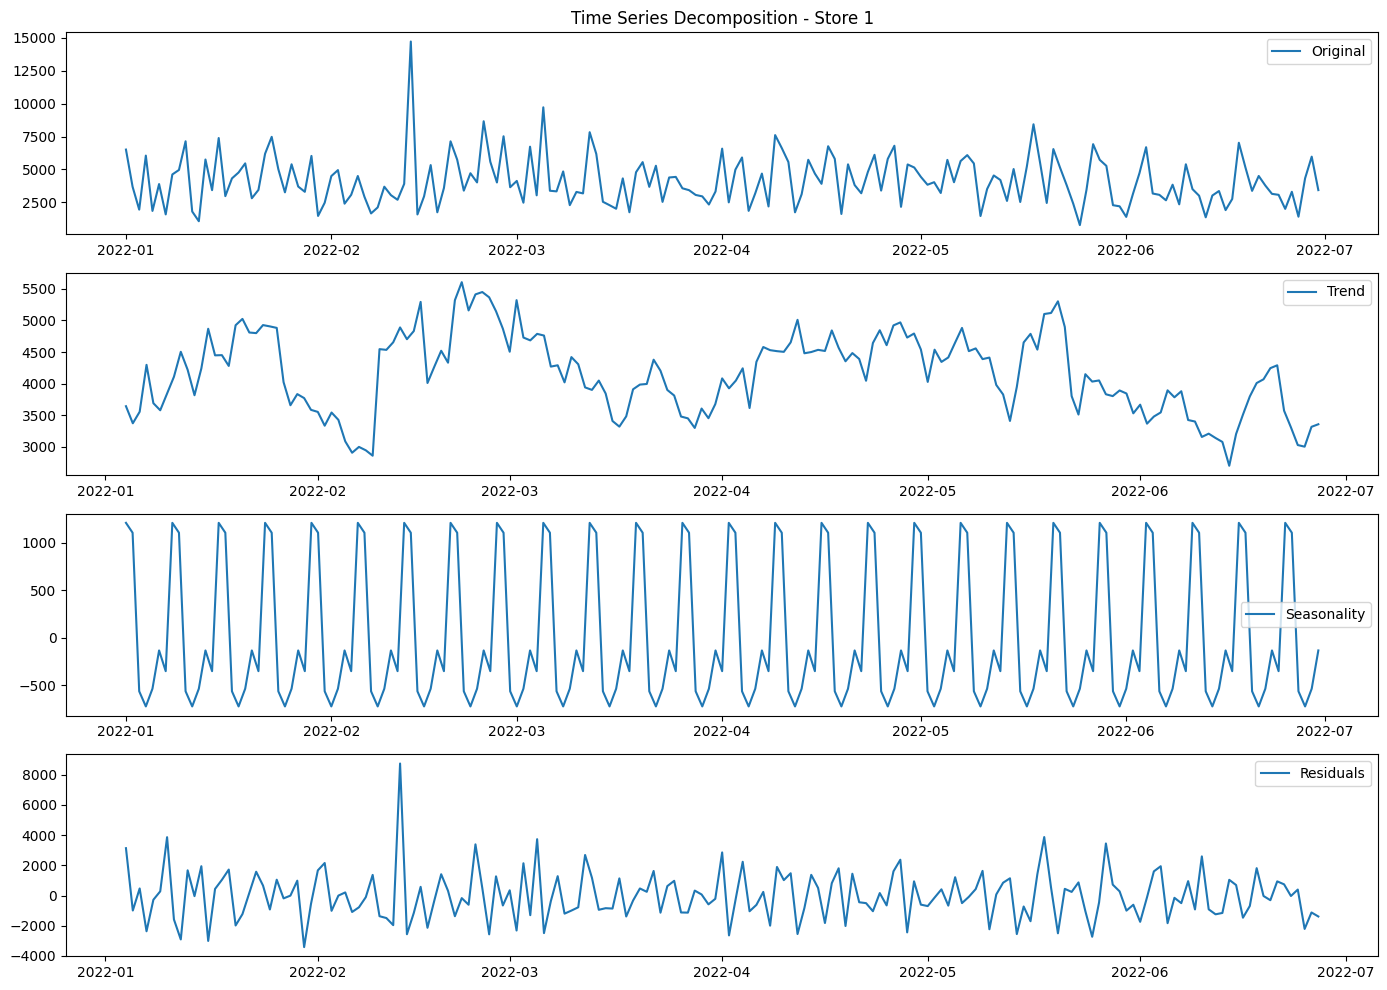

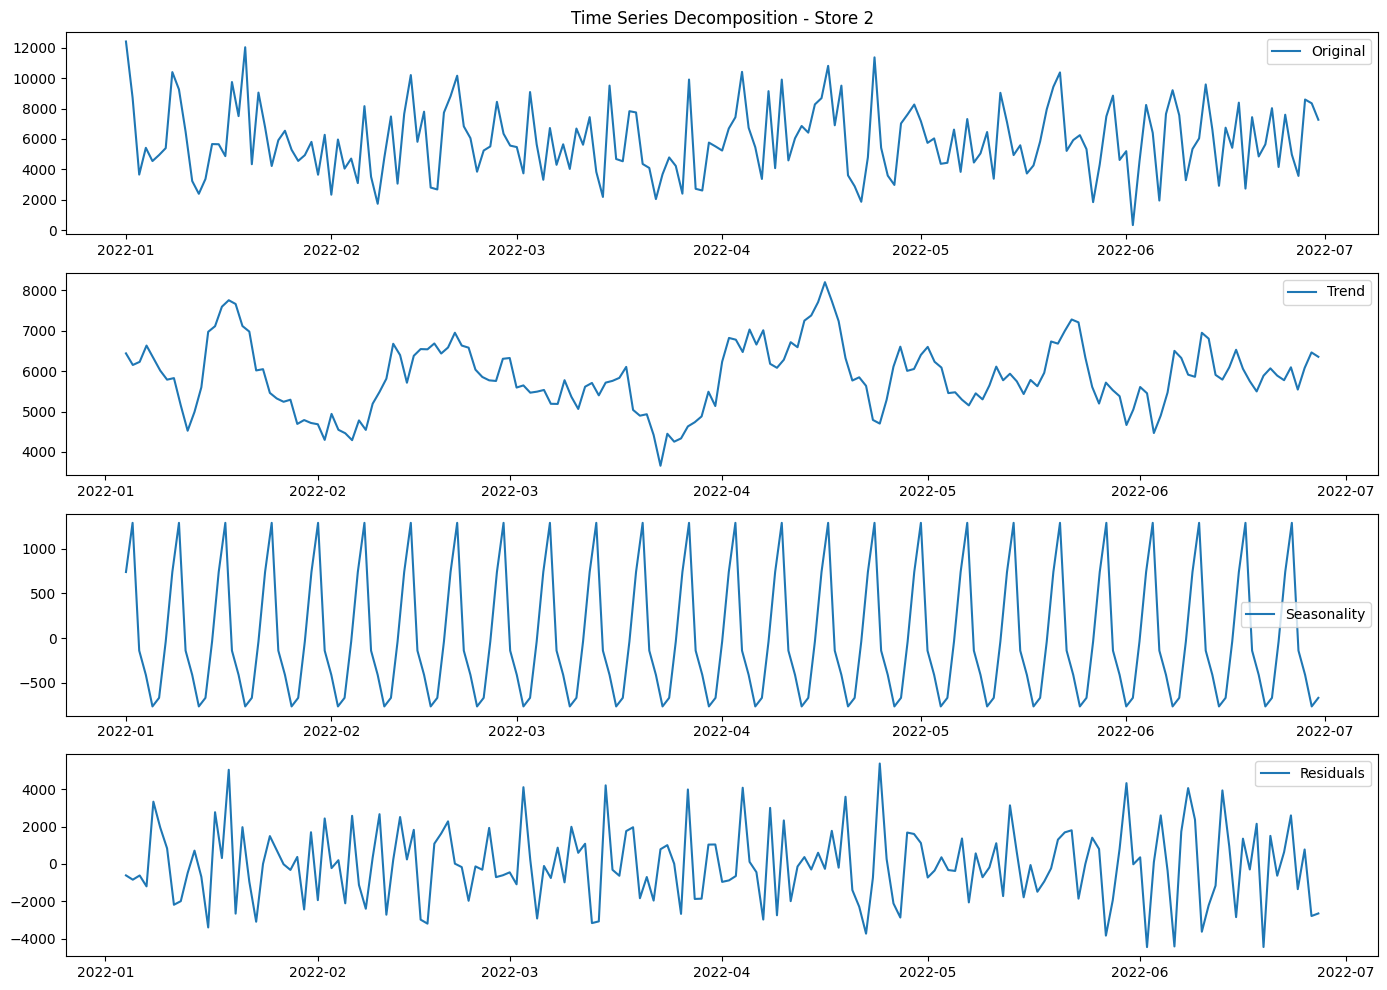

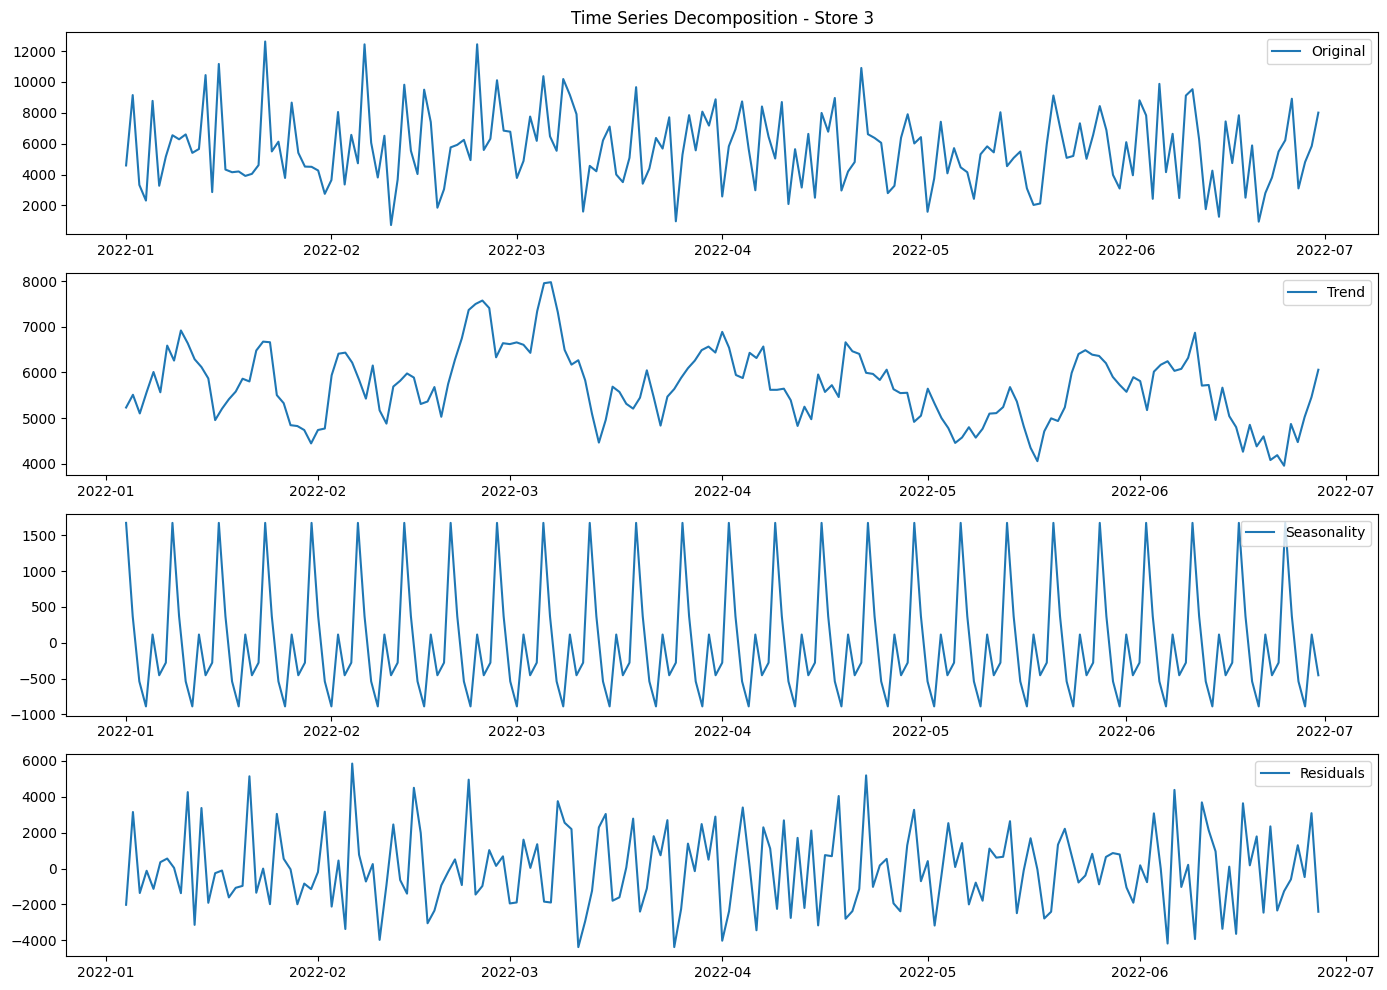

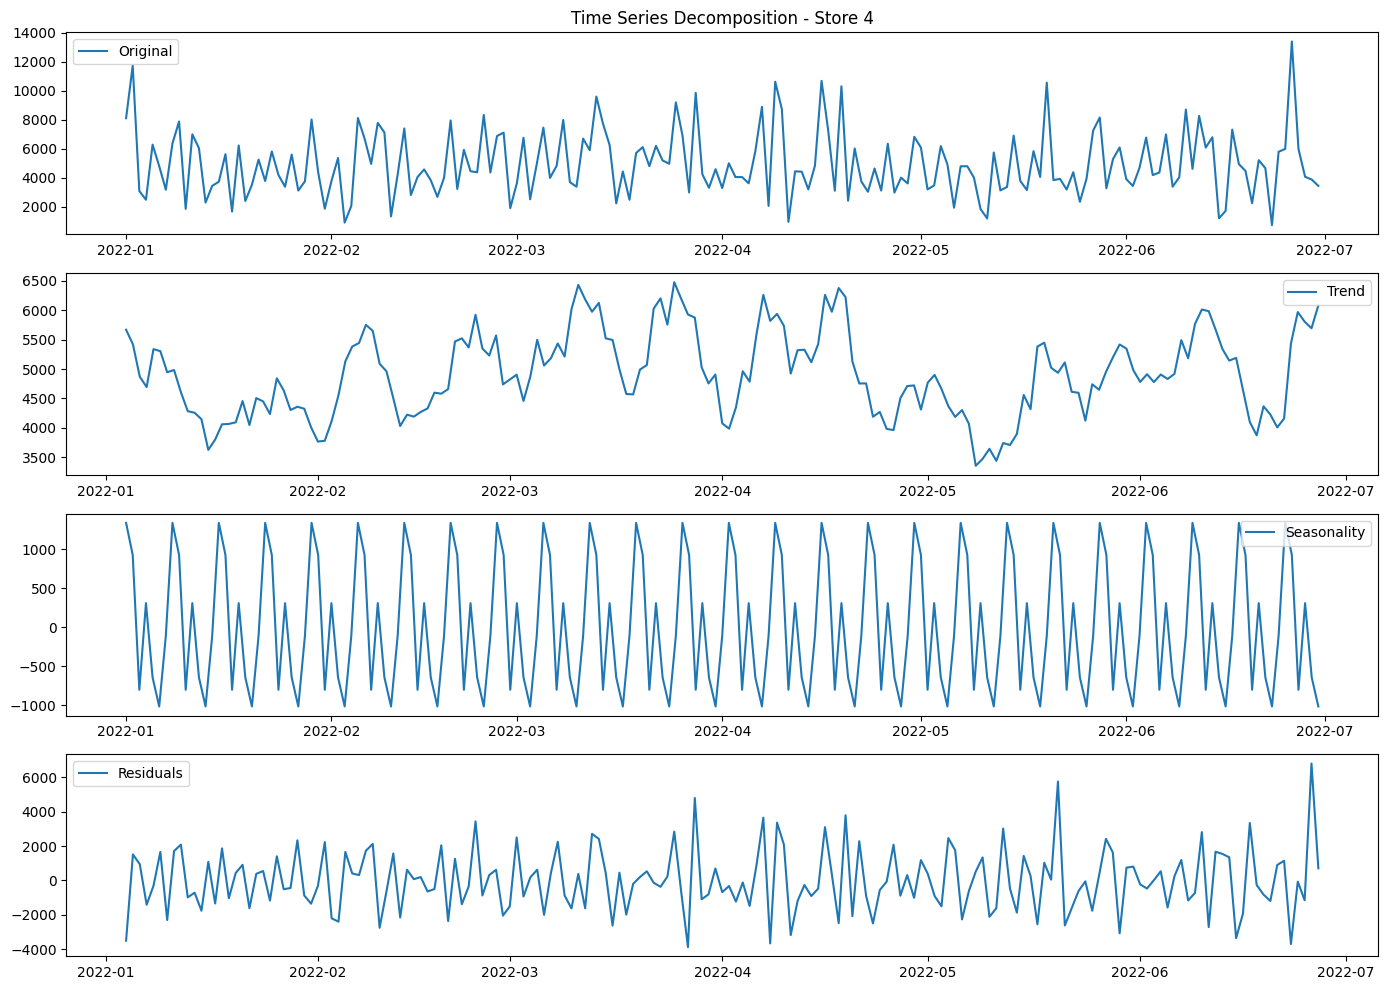

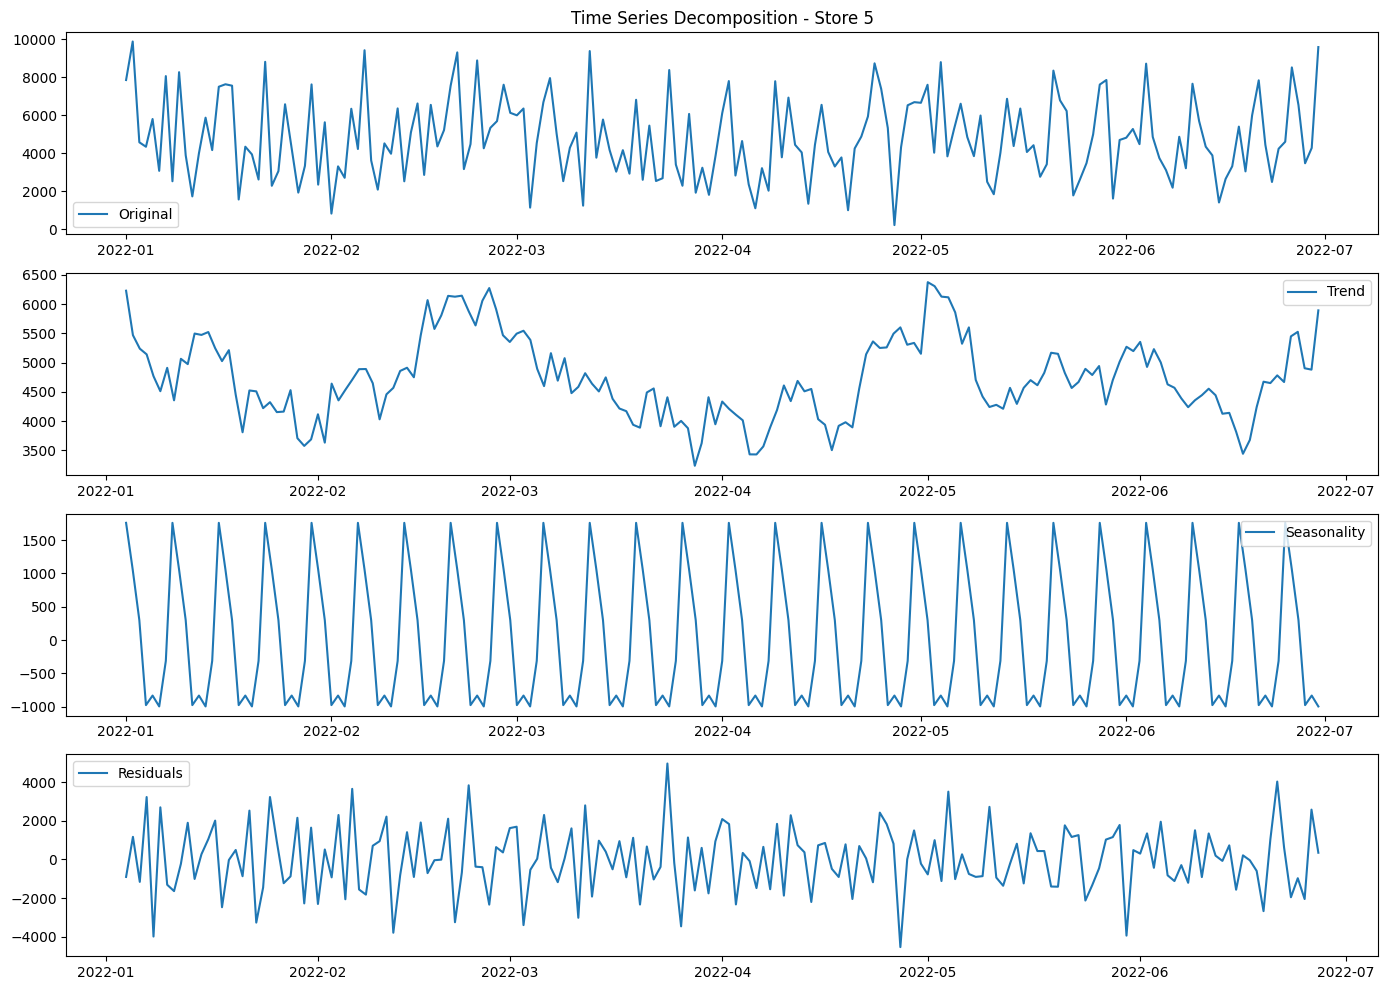

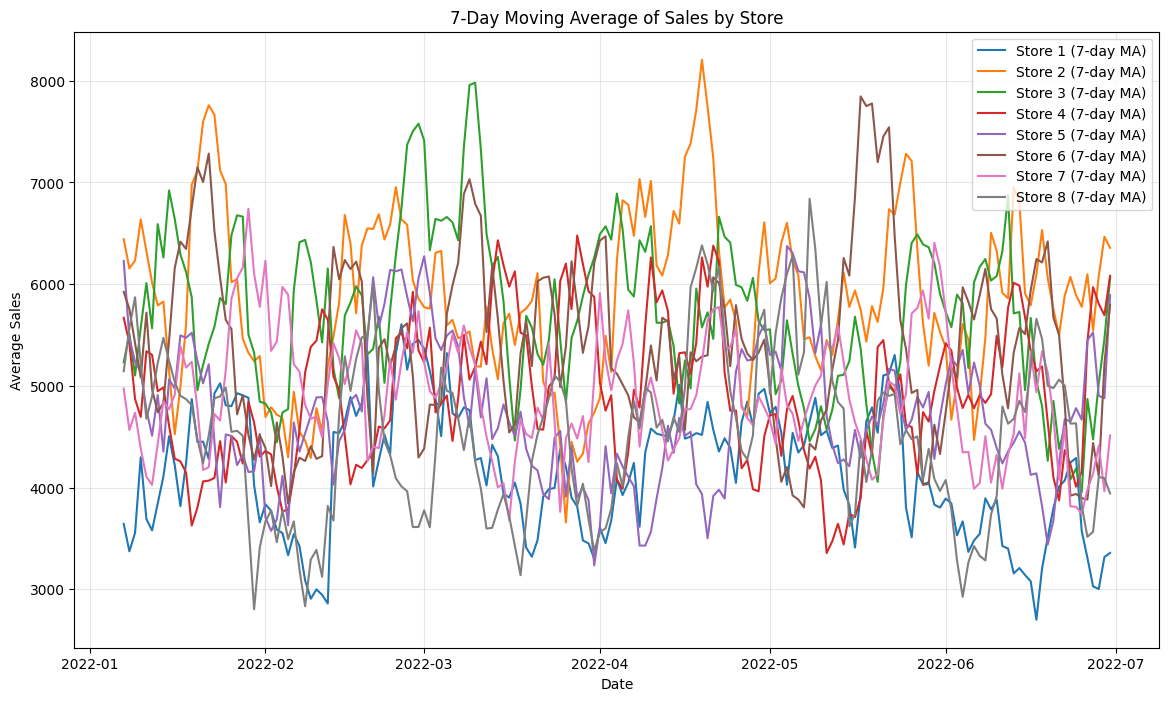

In [3]:
# 3.1 Time Series Decomposition for Each Store
for store in range(1, 6):  # Showing first 5 stores for brevity
    store_sales = store_data[f'Store_{store}'].dropna()
    
    # Check if we have enough data points for decomposition
    if len(store_sales) > 14:  # Minimum requirement for seasonal_decompose with freq=7
        result = seasonal_decompose(store_sales, model='additive', period=7)
        
        plt.figure(figsize=(14, 10))
        plt.subplot(411)
        plt.plot(store_sales, label='Original')
        plt.legend(loc='best')
        plt.title(f'Time Series Decomposition - Store {store}')
        
        plt.subplot(412)
        plt.plot(result.trend, label='Trend')
        plt.legend(loc='best')
        
        plt.subplot(413)
        plt.plot(result.seasonal, label='Seasonality')
        plt.legend(loc='best')
        
        plt.subplot(414)
        plt.plot(result.resid, label='Residuals')
        plt.legend(loc='best')
        
        plt.tight_layout()
        plt.show()

# 3.2 Rolling Statistics - Moving Averages
plt.figure(figsize=(14, 8))
for store_id in range(1, 9):  # All 8 stores
    if f'Store_{store_id}' in store_data.columns:
        store_series = store_data[f'Store_{store_id}']
        plt.plot(store_series.rolling(window=7).mean(), 
                 label=f'Store {store_id} (7-day MA)')

plt.title('7-Day Moving Average of Sales by Store')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Advanced Time Series Clustering

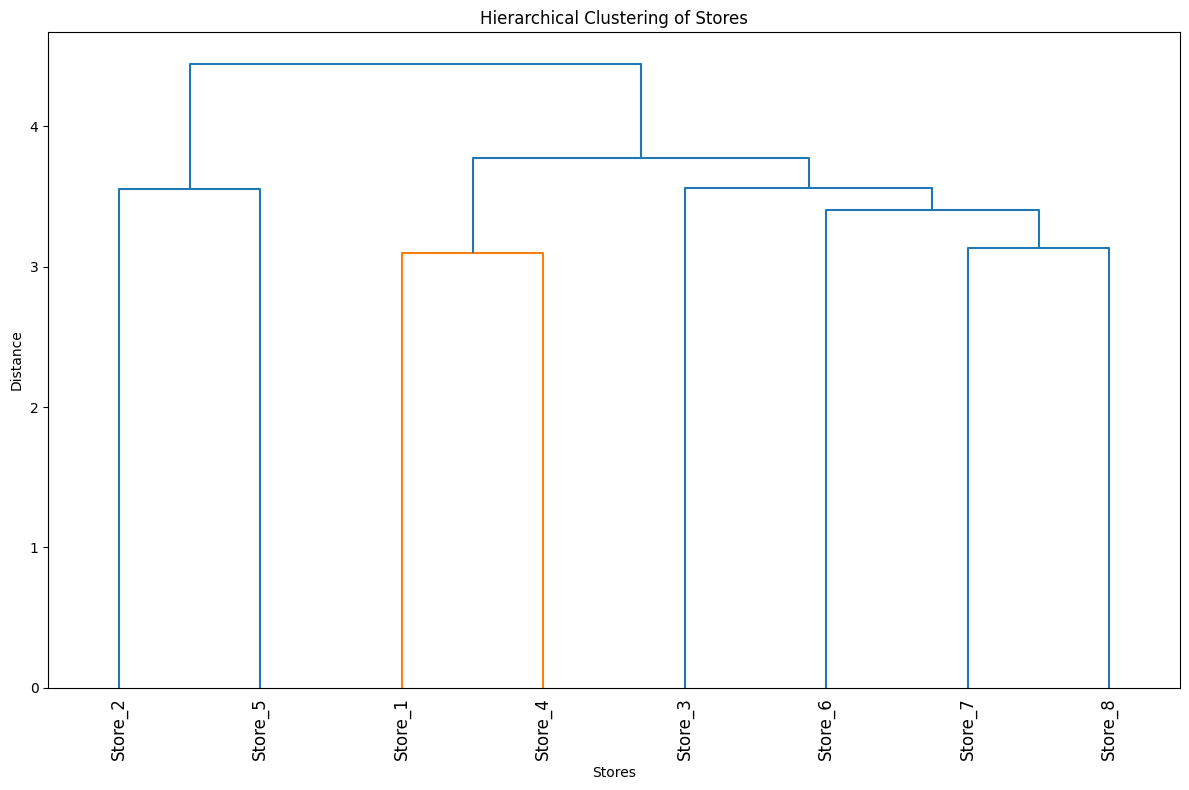

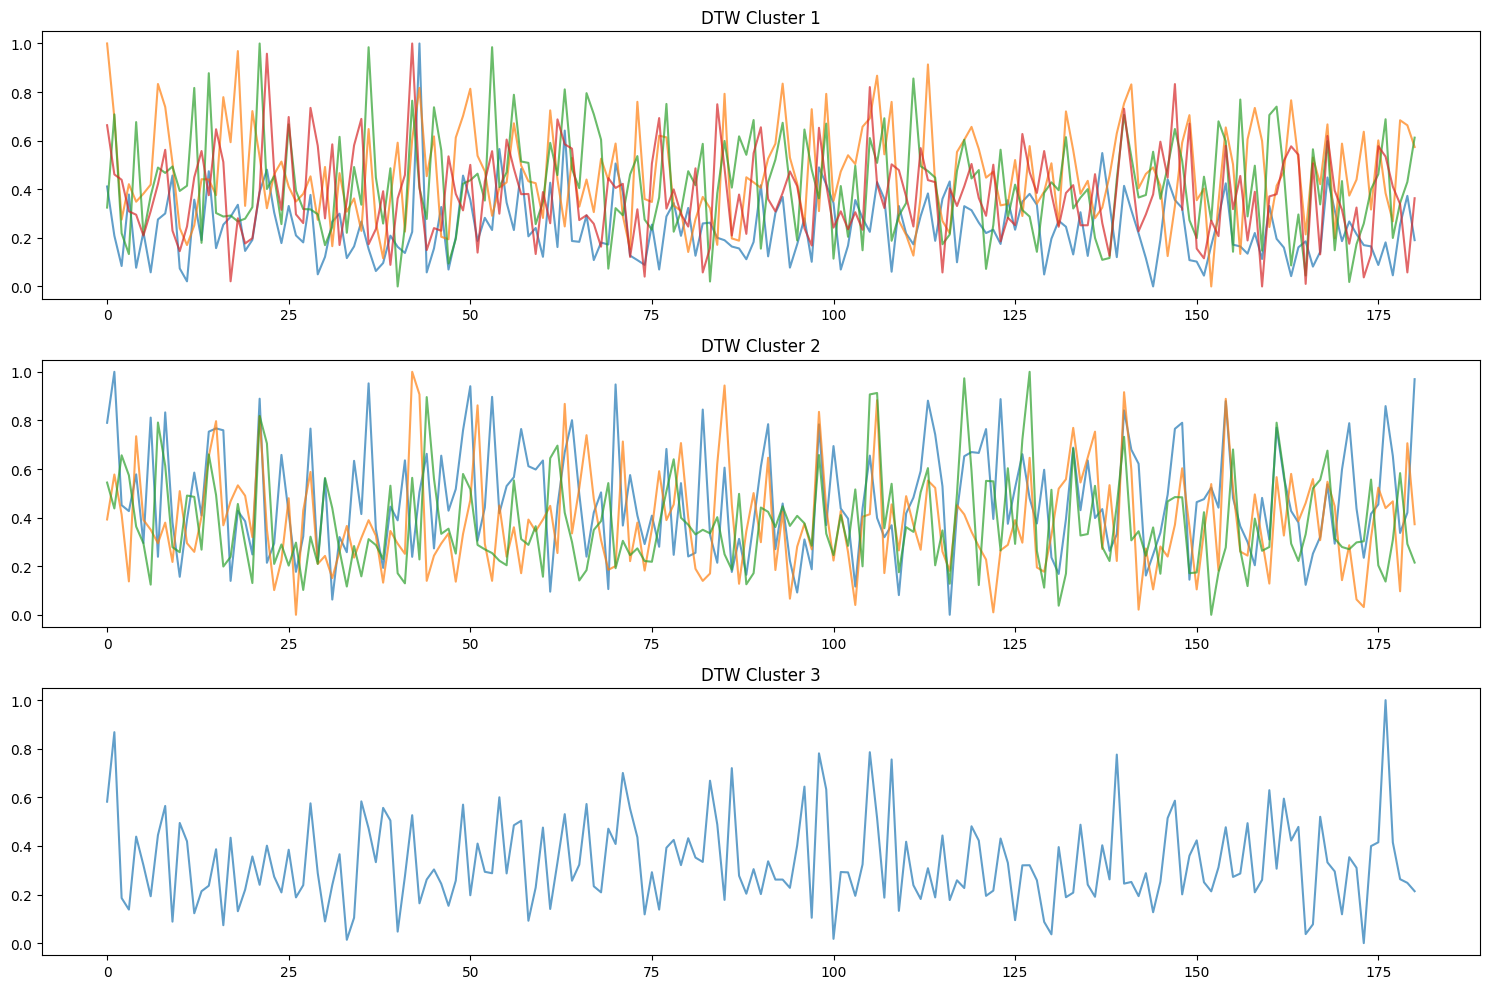

In [4]:
# Prepare data for clustering
X = np.array([store_data[col].values for col in store_data.columns if not np.isnan(store_data[col]).any()])
store_names = [col for col in store_data.columns if not np.isnan(store_data[col]).any()]

# Normalize the time series
scaler = MinMaxScaler()
X_scaled = np.array([scaler.fit_transform(x.reshape(-1, 1)).flatten() for x in X])

# 4.1 Hierarchical Clustering with Dendrogram
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(Z, labels=store_names, leaf_rotation=90)
plt.title('Hierarchical Clustering of Stores')
plt.xlabel('Stores')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# 4.2 Dynamic Time Warping Clustering
# DTW-based KMeans using tslearn
ts_data = TimeSeriesScalerMeanVariance().fit_transform(X_scaled[:, :, np.newaxis])
n_clusters = 3  # We can determine optimal clusters through silhouette analysis

# DTW-KMeans
dba_km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
dba_labels = dba_km.fit_predict(ts_data)

# Visualize clusters
plt.figure(figsize=(15, 10))
for cluster in range(n_clusters):
    plt.subplot(n_clusters, 1, cluster + 1)
    for i in range(len(X_scaled)):
        if dba_labels[i] == cluster:
            plt.plot(X_scaled[i], alpha=0.7, label=store_names[i] if i == 0 else "")
    plt.title(f'DTW Cluster {cluster+1}')
    plt.tight_layout()
plt.show()

## SAX-based Analysis (from reference)

SAX Clustering Results:
Cluster 0: Store_3, Store_5
Cluster 1: Store_2, Store_6, Store_7, Store_8
Cluster 2: Store_1, Store_4


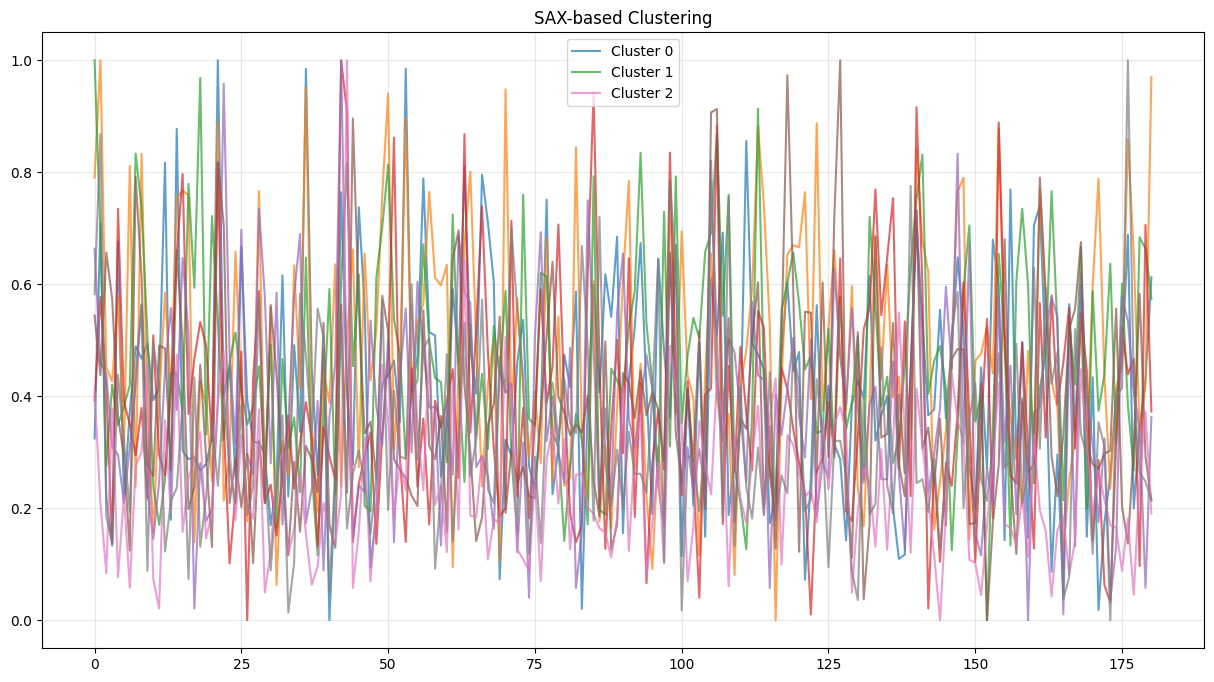

In [5]:
# Implementation of SAX from reference
import numpy as np
from scipy.stats import norm

def paa(series, word_size):
    """
    Piecewise Aggregate Approximation
    """
    segment_size = len(series) // word_size
    paa_result = np.array([np.mean(series[i*segment_size:(i+1)*segment_size]) 
                          for i in range(word_size)])
    return paa_result

def series_to_symbols(paa_series, alphabet_size):
    """
    Convert normalized series to symbolic representation
    """
    breakpoints = norm.ppf(np.linspace(0, 1, alphabet_size+1)[1:-1])
    
    symbols = []
    for val in paa_series:
        symbol_idx = np.sum(val > breakpoints)
        symbols.append(chr(ord('a') + symbol_idx))
    
    return ''.join(symbols)

def apply_sax(data, word_size=12, alphabet_size=8, window_size=30):
    """Apply SAX to a set of time series"""
    sax_strings = []
    
    for ts in data:
        sax_repr = []
        for i in range(0, len(ts) - window_size + 1, window_size):
            window = ts[i:i+window_size]
            paa_repr = paa(window, word_size)
            sax_result = series_to_symbols(paa_repr, alphabet_size)
            sax_repr.append(sax_result)
        sax_strings.append(''.join(sax_repr))
    
    return sax_strings

# Create a distance matrix based on SAX representations
def sax_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

# Convert time series to SAX representation
sax_representations = apply_sax(X_scaled)

# Create distance matrix
sax_distance_matrix = np.zeros((len(X_scaled), len(X_scaled)))
for i in range(len(X_scaled)):
    for j in range(len(X_scaled)):
        sax_distance_matrix[i, j] = sax_distance(sax_representations[i], sax_representations[j])

# Apply KMeans clustering on SAX distance matrix
n_clusters = 3  # You can adjust this
kmeans_sax = KMeans(n_clusters=n_clusters, random_state=42)
sax_clusters = kmeans_sax.fit_predict(sax_distance_matrix)

print("SAX Clustering Results:")
for cluster in range(n_clusters):
    stores = [store_names[i] for i, c in enumerate(sax_clusters) if c == cluster]
    print(f"Cluster {cluster}: {', '.join(stores)}")

# Visualize SAX clusters
plt.figure(figsize=(15, 8))
for cluster in range(n_clusters):
    for i, store in enumerate([j for j in range(len(X_scaled)) if sax_clusters[j] == cluster]):
        if i == 0:  # Only add label for first store in cluster
            plt.plot(X_scaled[store], alpha=0.7, 
                     label=f'Cluster {cluster}')
        else:
            plt.plot(X_scaled[store], alpha=0.7)

plt.title('SAX-based Clustering')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Advanced Pattern Analysis

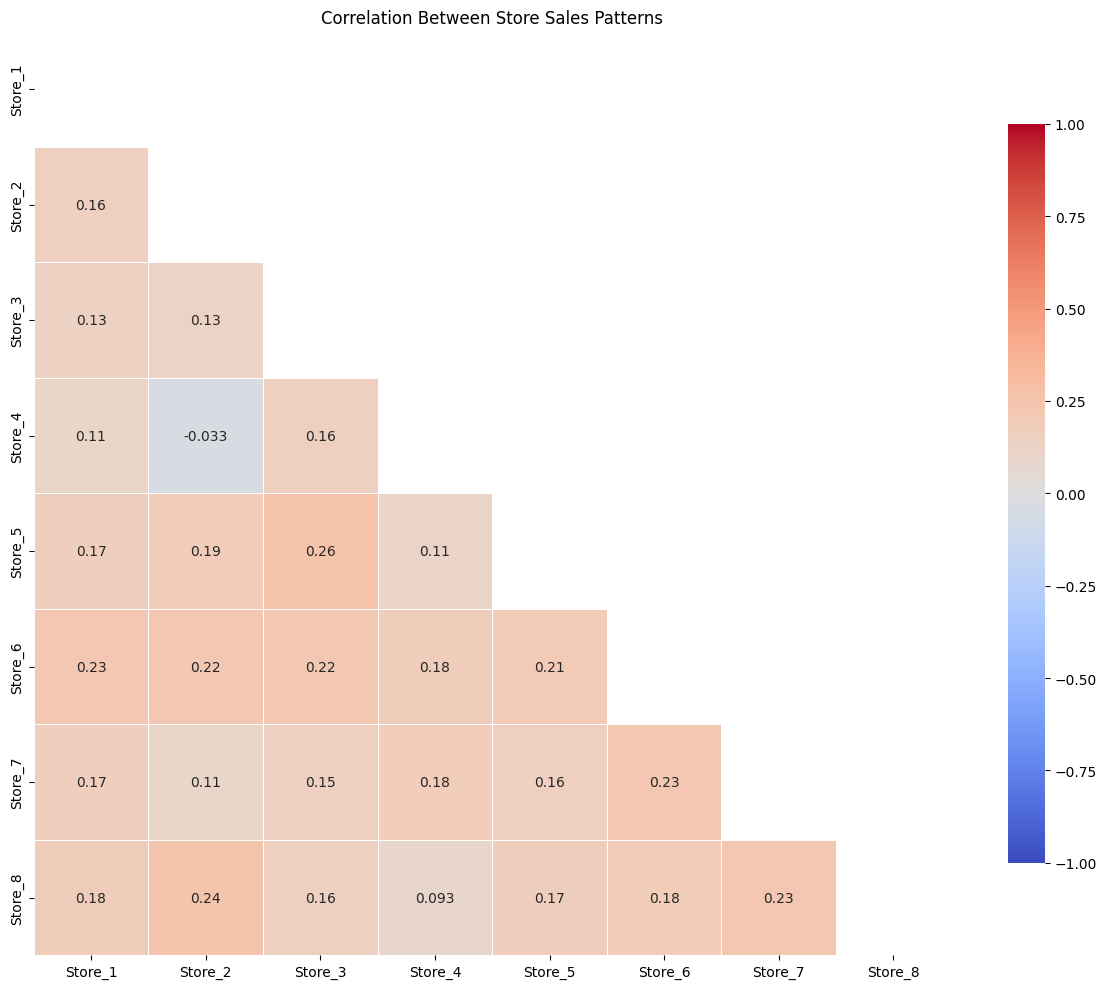

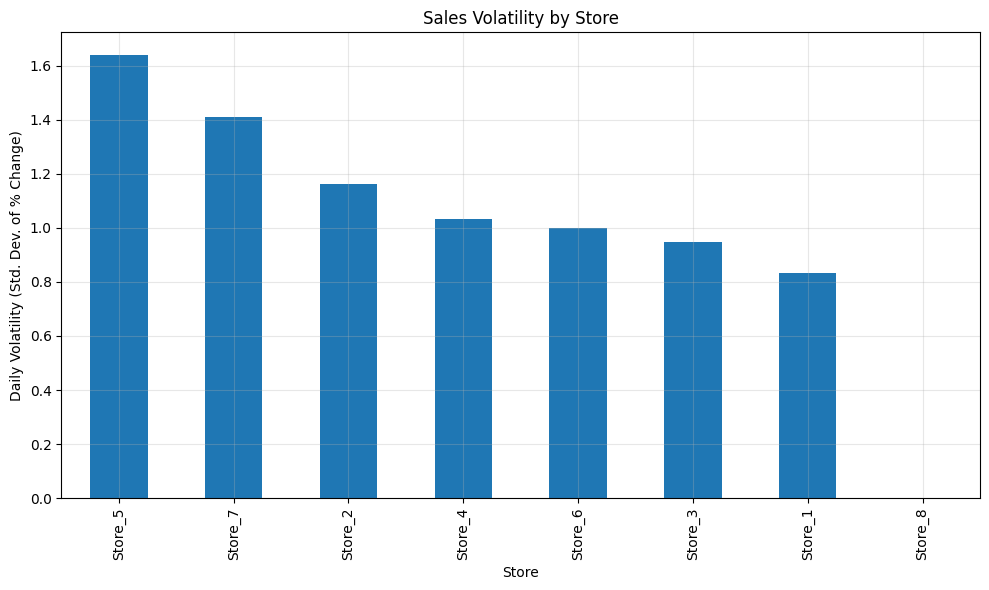

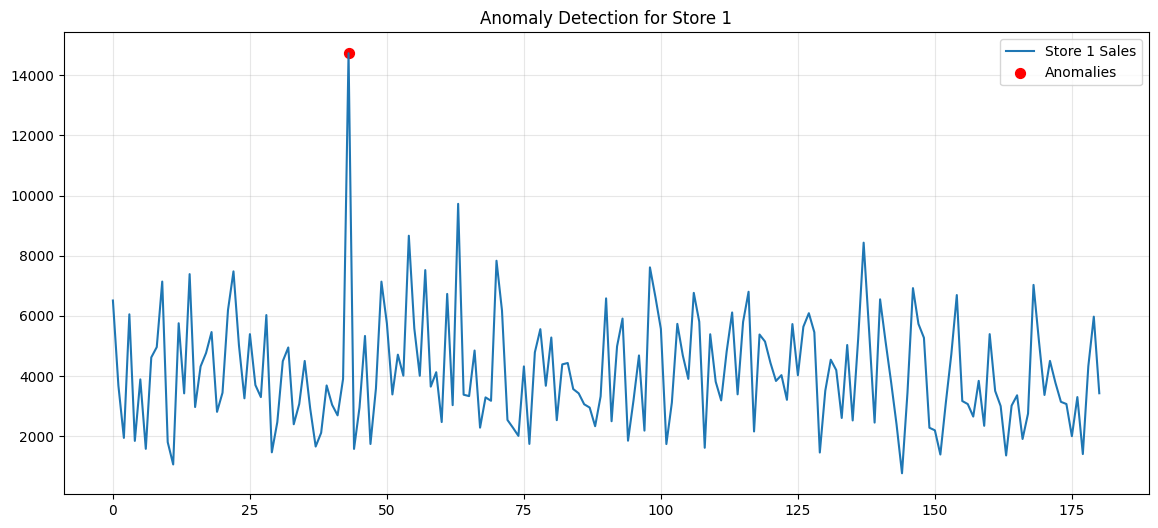

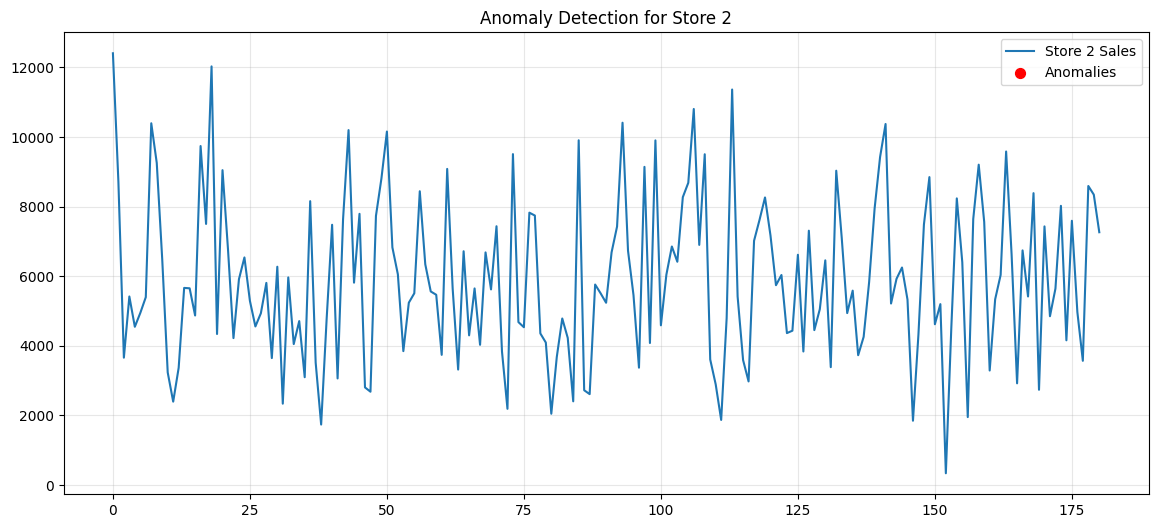

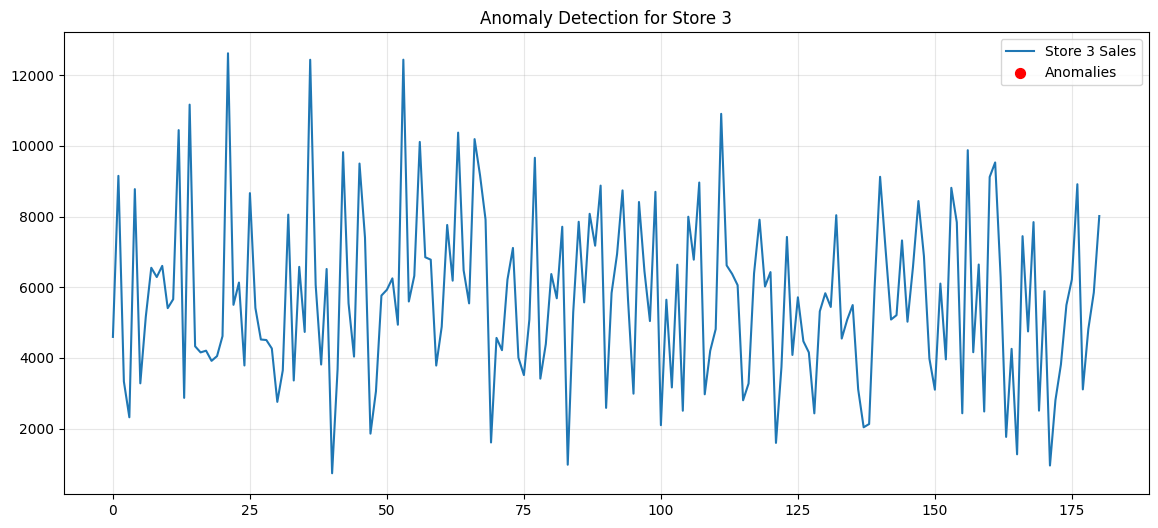

In [6]:
# 6.1 Correlation Heatmap Between Stores
corr_matrix = store_data.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1, 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Between Store Sales Patterns')
plt.tight_layout()
plt.show()

# 6.2 Sales Volatility Analysis
volatility = store_data.pct_change().std().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
volatility.plot(kind='bar')
plt.title('Sales Volatility by Store')
plt.xlabel('Store')
plt.ylabel('Daily Volatility (Std. Dev. of % Change)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6.3 Anomaly Detection using Z-score
def detect_anomalies(series, threshold=3):
    mean = np.mean(series)
    std = np.std(series)
    z_scores = [(y - mean) / std for y in series]
    return np.where(np.abs(z_scores) > threshold)[0]

# Plot anomalies for each store
for store_id in range(1, 4):  # Just showing for first 3 stores
    if f'Store_{store_id}' in store_data.columns:
        store_series = store_data[f'Store_{store_id}'].values
        anomalies_idx = detect_anomalies(store_series)
        
        plt.figure(figsize=(14, 6))
        plt.plot(store_series, label=f'Store {store_id} Sales')
        plt.scatter(anomalies_idx, store_series[anomalies_idx], color='red', 
                    label='Anomalies', s=50)
        plt.title(f'Anomaly Detection for Store {store_id}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

## Autoencoder-based Pattern Recognition (from reference)

Epoch [20/100], Loss: 0.0363
Epoch [40/100], Loss: 0.0248
Epoch [60/100], Loss: 0.0280
Epoch [80/100], Loss: 0.0146
Epoch [100/100], Loss: 0.0218


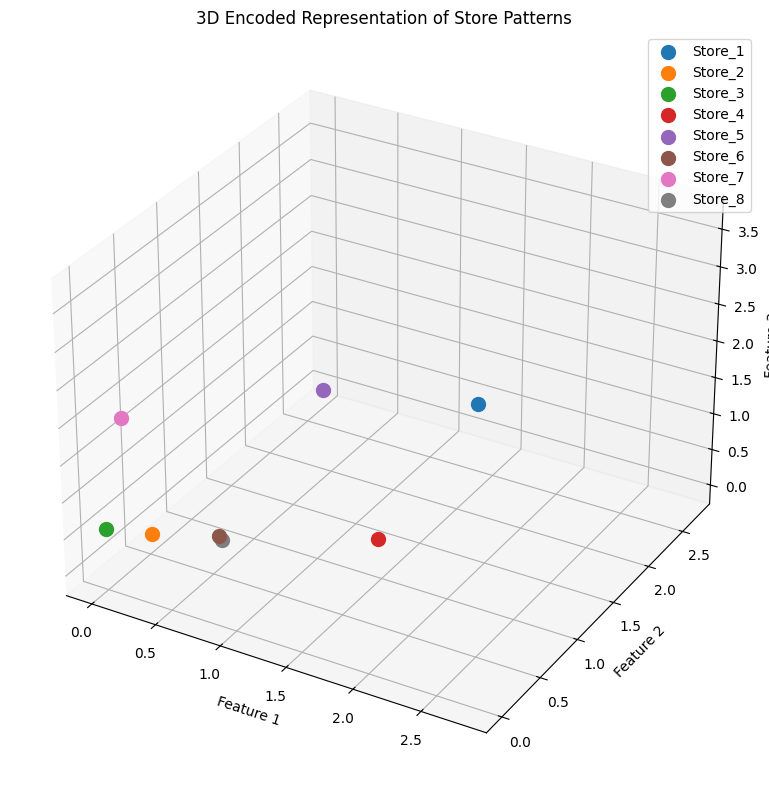

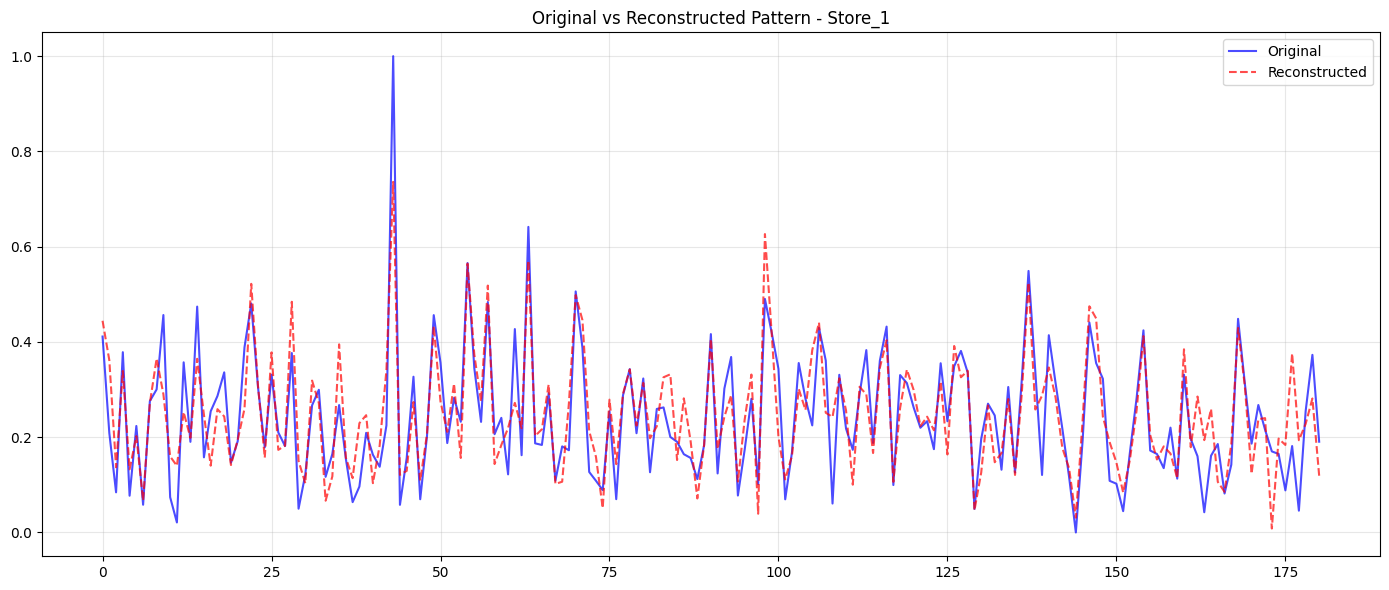

In [7]:
# Autoencoder implementation from reference but modified for better visualization
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=8):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

# Prepare data for autoencoder
X_tensor = torch.FloatTensor(X_scaled)
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Initialize and train autoencoder
input_dim = X_scaled.shape[1]  # Number of time points
autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=3)  # 3D for visualization

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training
epochs = 100
for epoch in range(epochs):
    for x_batch, _ in dataloader:
        outputs = autoencoder(x_batch)
        loss = criterion(outputs, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Extract encoded features for visualization
autoencoder.eval()
with torch.no_grad():
    encoded_features = autoencoder.encode(X_tensor).numpy()

# Visualize encoded features in 3D
if encoded_features.shape[1] == 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for i, store in enumerate(store_names):
        ax.scatter(encoded_features[i, 0], 
                   encoded_features[i, 1], 
                   encoded_features[i, 2],
                   marker='o', s=100, label=store)
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.set_title('3D Encoded Representation of Store Patterns')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize original vs reconstructed for one store
with torch.no_grad():
    # Get reconstruction
    reconstructed = autoencoder(X_tensor).numpy()
    
    # Plot original vs reconstructed for first store
    plt.figure(figsize=(14, 6))
    plt.plot(X_scaled[0], label='Original', color='blue', alpha=0.7)
    plt.plot(reconstructed[0], label='Reconstructed', color='red', linestyle='--', alpha=0.7)
    plt.title(f'Original vs Reconstructed Pattern - {store_names[0]}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Gemini Analysis

### Plot 1: Original vs Reconstructed Pattern - Store_1

This plot is a **diagnostic and validation tool** for the machine learning model.

*   **What it Shows:** It compares the original time series data for a single store ("Store_1") with the version that the model has "reconstructed".
    *   **Original (Blue Line):** This is the actual, ground-truth time series data for Store_1 (e.g., daily sales, traffic, etc., likely normalized to be between 0 and 1). It represents the complex, high-dimensional reality.
    *   **Reconstructed (Red Dashed Line):** This is the model's best attempt at recreating the original data *after* first compressing it into a very small, simplified representation.

*   **Interpretation:**
    *   The fact that the red line closely follows the general shape, peaks, and troughs of the blue line is a **good sign**. It means the model was successful.
    *   It successfully captured the essential patterns (the "signal") of the original data in its compressed format, while filtering out some of the finer-grained details (the "noise").
    *   The goal isn't a perfect 1:1 copy. The goal is to prove that the compressed summary is meaningful, and this plot confirms that it is.

---

### Plot 2: 3D Encoded Representation of Store Patterns

This plot is the **payoff**. It visualizes the powerful, simplified summaries that the model created for each store.

*   **What it Shows:** This is a 3D scatter plot where each point represents an **entire time series** for one store.
    *   The original, long time series for each store (like the blue line in Plot 1, which has ~180 data points) has been compressed by the model's **encoder** into just **three numbers**.
    *   These three numbers are plotted as coordinates along the "Feature 1", "Feature 2", and "Feature 3" axes.

*   **Interpretation:**
    *   **The key insight is that proximity in this 3D space implies similarity in behavior.**
    *   **Clustering:** Stores that are close to each other in this plot (e.g., Store_6 and Store_8) have similar time series patterns. They might have similar weekly sales cycles, respond similarly to promotions, or have a similar customer base.
    *   **Outliers:** A store that is far away from all others (e.g., Store_1 appears quite distinct from the main group) has a unique pattern. This could be a flagship store, a store in a unique location, or one with performance issues.
    *   **Abstract Features:** The axes ("Feature 1", "Feature 2", "Feature 3") are not pre-defined things like "average sales" or "seasonality". They are abstract features that the model learned on its own were most important for distinguishing between the stores' patterns. For example, Feature 1 might have captured the overall sales volume, while Feature 2 might have captured the strength of weekend peaks.

### Putting It All Together

1.  An **autoencoder** was trained on time series data from 8 different stores.
2.  **Plot 1** shows that for Store_1, the model can compress its data and then reconstruct it well, validating that the compression is meaningful.
3.  **Plot 2** takes the compressed representations (called "encodings" or "latent vectors") for all 8 stores and plots them. This allows us to visually **cluster stores based on their sales patterns**.

This analysis could be used for:
*   **Targeted Marketing:** Create campaigns for clusters of similar stores.
*   **Inventory Management:** Group stores with similar demand patterns for more efficient supply chain logistics.
*   **Performance Benchmarking:** Compare a store's performance to others in its cluster, rather than to a general average.

## Seasonal Pattern Analysis

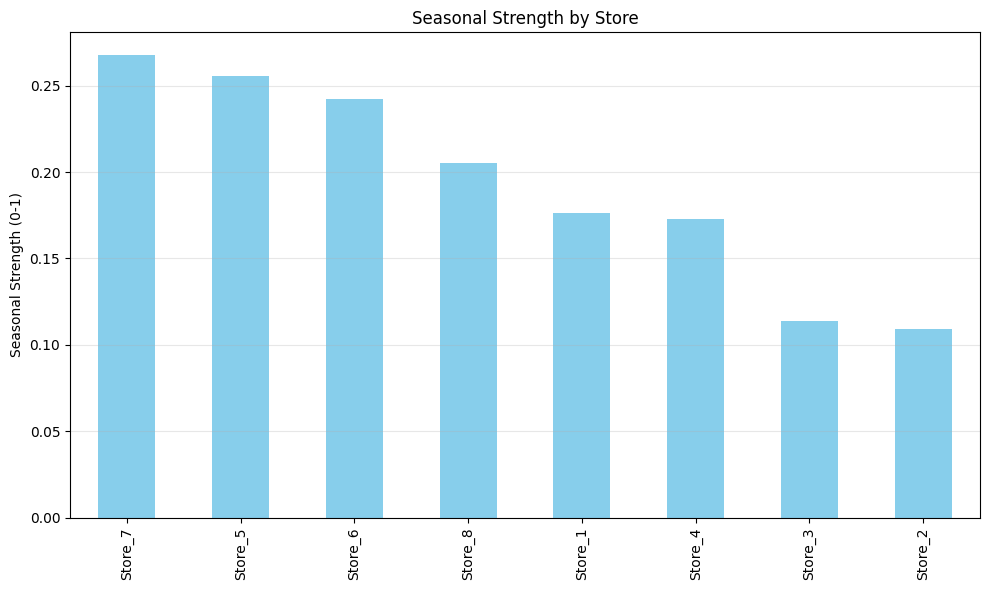

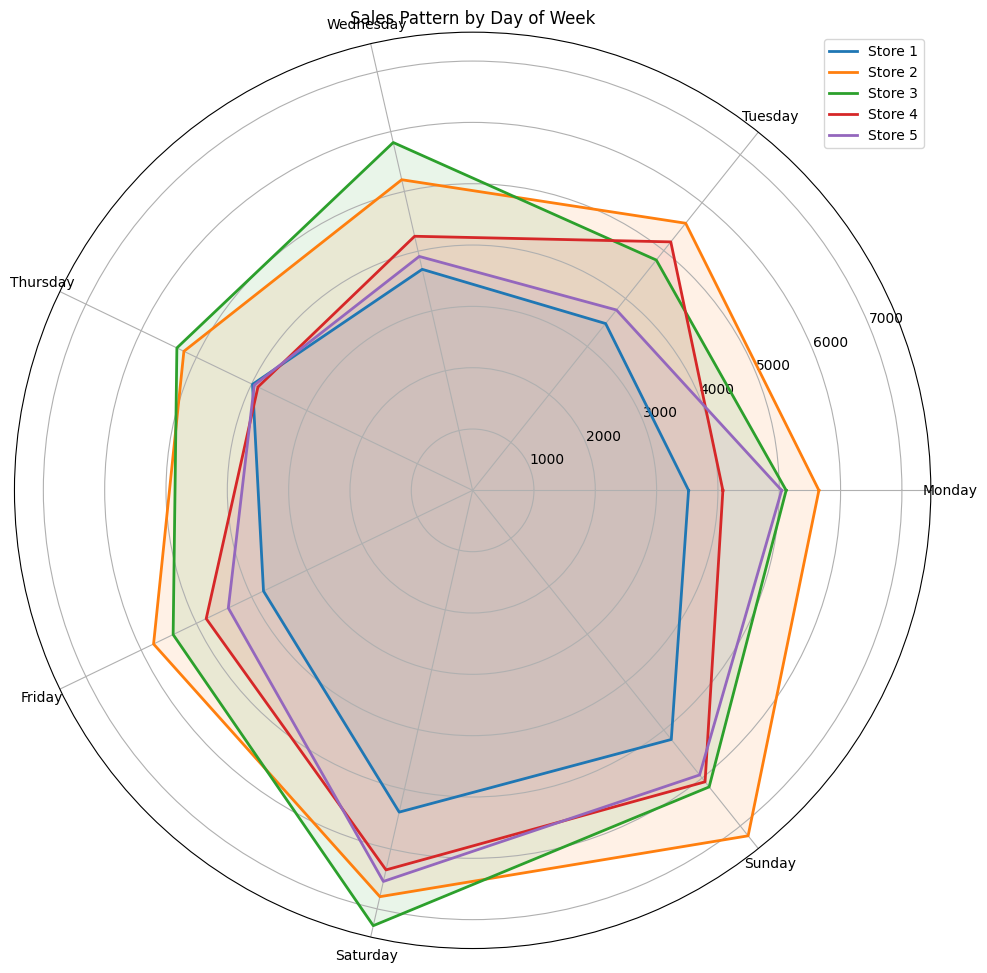

In [8]:
# 8.1 Seasonality Strength Visualization
def seasonal_strength(series, period=7):
    """Calculate seasonal strength index"""
    # Use STL decomposition to extract seasonality
    decomp = seasonal_decompose(series, model='additive', period=period)
    
    # Calculate seasonal strength
    var_resid = np.var(decomp.resid.dropna())
    var_seasonal = np.var(decomp.seasonal.dropna())
    
    if var_resid + var_seasonal == 0:
        return 0
    
    strength = max(0, 1 - var_resid / (var_resid + var_seasonal))
    return strength

# Calculate seasonal strength for each store
seasonal_strengths = {}
for col in store_data.columns:
    series = store_data[col].dropna()
    if len(series) >= 14:  # Need at least 2 periods for decomposition
        seasonal_strengths[col] = seasonal_strength(series)

# Visualize seasonal strength
if seasonal_strengths:
    plt.figure(figsize=(10, 6))
    strengths = pd.Series(seasonal_strengths)
    strengths.sort_values(ascending=False).plot(kind='bar', color='skyblue')
    plt.title('Seasonal Strength by Store')
    plt.ylabel('Seasonal Strength (0-1)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 8.2 Polar Seasonal Plots (Sales by Day of Week)
# This creates a radar/polar chart showing sales patterns by day of week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = df_long.pivot_table(index='DayOfWeek', columns='StoreID', values='Sales', aggfunc='mean')
day_avg = day_avg.reindex(days)  # Reorder days

# Plot in polar coordinates
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

angles = np.linspace(0, 2*np.pi, len(days), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

for store_id in range(1, min(6, len(day_avg.columns)+1)):  # Max 5 stores for clarity
    if store_id in day_avg.columns:
        values = day_avg[store_id].values.flatten().tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, label=f'Store {store_id}')
        ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(days)
ax.set_title('Sales Pattern by Day of Week')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Conclusion and Pattern Summary

Summary Statistics:


count         mean          std     min      25%      50%      75%  \
Store_1  181.0  4151.034365  1899.064941  767.26  2951.55  3811.33  5388.60   
Store_2  181.0  5917.194807  2318.578260  336.99  4257.75  5645.10  7503.09   
Store_3  181.0  5712.086851  2427.132943  734.16  4006.68  5596.59  7112.26   
Store_4  181.0  4950.340000  2263.002416  733.43  3381.93  4454.11  6230.68   
Store_5  181.0  4797.012541  2151.894531  225.10  3214.81  4424.58  6360.57   
Store_6  181.0  5411.871657  2472.029107  794.94  3714.34  5030.93  6733.10   
Store_7  181.0  4912.210442  2162.759279  447.92  3357.56  4914.12  6179.77   
Store_8  181.0  4537.409116  2318.677755    0.00  2949.87  3986.07  6112.63   

              max  Volatility  Seasonality  
Store_1  14728.32    0.834637     0.176467  
Store_2  12407.68    1.163701     0.109378  
Store_3  12622.10    0.948871     0.113962  
Store_4  13406.79    1.031140     0.172685  
Store_5   9878.44    1.641646     0.255479  
Store_6  12777.96    1.000664     0.242060  
Store_7  12236.29    1.411614     0.267462  
Store_8  12025.72         NaN     0.205005

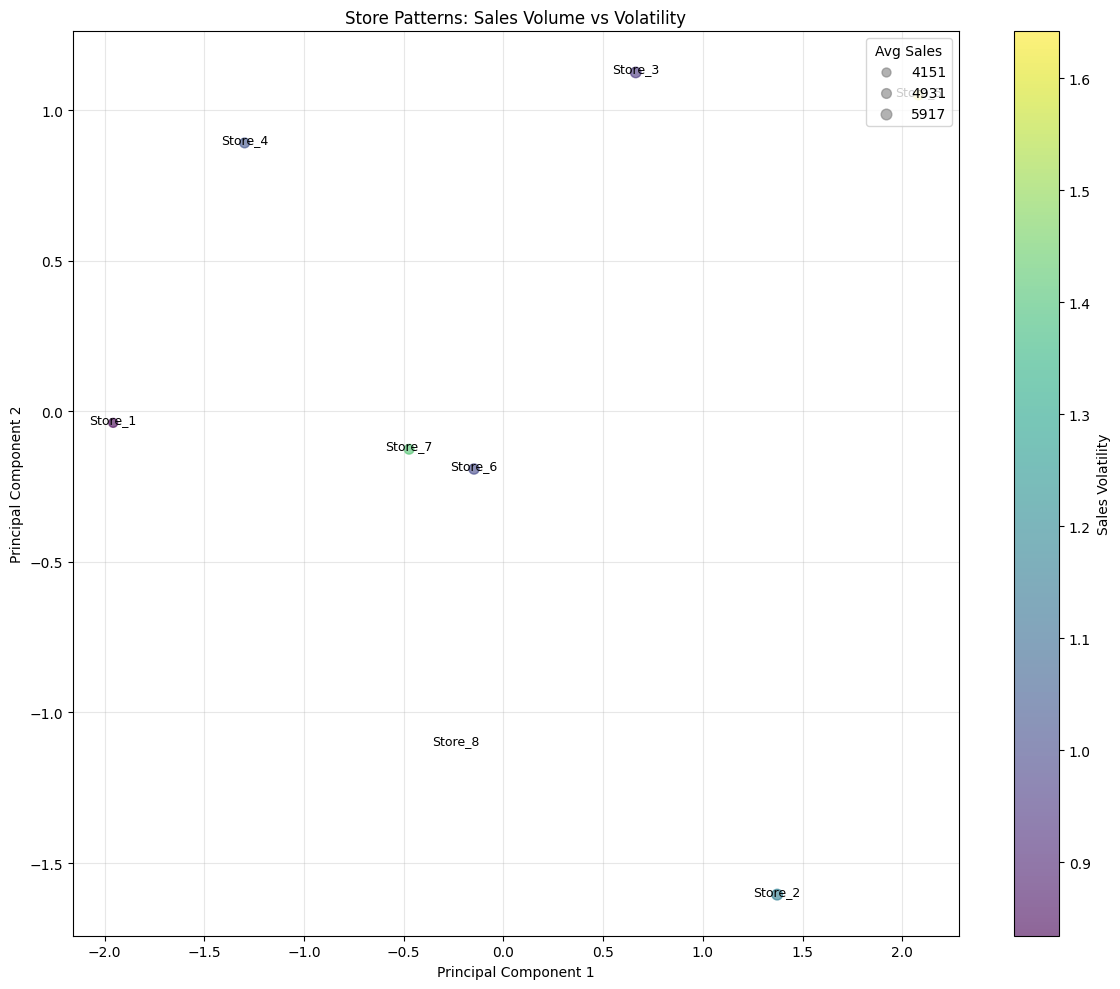

In [9]:
# 9.1 Summary Statistics Table
summary = store_data.describe().T
summary['Volatility'] = store_data.pct_change().std()

# Add other calculated metrics if available
if 'seasonal_strengths' in locals():
    for store, strength in seasonal_strengths.items():
        if store in summary.index:
            summary.loc[store, 'Seasonality'] = strength

print("Summary Statistics:")
display(summary)

# 9.2 Final Cluster Visualization with Store Performance Overlay
# Using the autoencoder clusters but visualizing with performance info
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_scaled)

# Get store performance metrics
avg_sales = [store_data[name].mean() for name in store_names]
sales_volatility = [store_data[name].pct_change().std() for name in store_names]

# Plot stores in 2D space with bubble size = avg sales, color = volatility
plt.figure(figsize=(12, 10))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                     s=[sales*0.01 for sales in avg_sales],  # Size based on sales
                     c=sales_volatility,  # Color based on volatility
                     alpha=0.6, cmap='viridis')

# Add store labels
for i, name in enumerate(store_names):
    plt.annotate(name, (pca_features[i, 0], pca_features[i, 1]),
                fontsize=9, ha='center')

# Add colorbar for volatility
plt.colorbar(scatter, label='Sales Volatility')

# Add legend for bubble size
sizes = [min(avg_sales), np.median(avg_sales), max(avg_sales)]
labels = [f"{int(s)}" for s in sizes]
leg_bubbles = [plt.scatter([], [], s=s*0.01, color='gray', alpha=0.6) for s in sizes]
plt.legend(leg_bubbles, labels, title="Avg Sales", loc="upper right", 
           scatterpoints=1, frameon=True)

plt.title('Store Patterns: Sales Volume vs Volatility')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This comprehensive analysis provides multiple ways to explore, visualize, and understand the time series patterns in your retail dataset. The code includes:

- Basic time series visualization with interactive Plotly charts
- Day-of-week patterns using heatmaps
- Time series decomposition to understand trend, seasonality, and residuals
- Multiple clustering approaches (SAX, Hierarchical, DTW, Autoencoder)
- Advanced pattern recognition with autoencoders
- Anomaly detection
- Polar/radar charts for weekly patterns
- 3D visualization of encoded store patterns
- Final summary with integrated performance metrics